In [57]:
import numpy as np
import pandas as pd

In [58]:
data=pd.read_excel("Manually_Tagged_Sheet.xlsx",sheet_name="Valid Entries_updated_15_06_202")
# data.head()
data=data.drop(columns=["exact_matched_patt","spacy_format_v1","spacy_format_v1","summaries_matching"])
data.columns=["id","summaries","exact_matched_patt_contextual","Tech_from_string_match"]

In [59]:
data=data.loc[:2500]
# data=data.sort_values(by=['id'])
# data=data.reset_index(drop=True)
# len(data)

In [60]:
train = data.loc[:2000]
test = data.loc[2001:]

In [61]:
len(train),len(test)

(2001, 500)

In [62]:
train.to_csv("Manual_TAGGED_2001_TRAIN.csv")
test.to_csv("Manual_TAGGED_500_TEST.csv")

In [63]:
data=train

In [64]:
#replacing null vals with empty list
data['exact_matched_patt_contextual'] = [ [] if x is np.NaN else x for x in data['exact_matched_patt_contextual'] ]


In [65]:
import nltk
import re
from bs4 import BeautifulSoup

nltk.download("punkt")

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    return text


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mohitbagaria/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [66]:
# for i, l in enumerate(data["exact_matched_patt_contextual"]):
#  print("list",i,"is",type(l))

In [67]:
data['exact_matched_patt_contextual']=data['exact_matched_patt_contextual'].astype(str)

In [68]:
# for i, l in enumerate(data["exact_matched_patt_contextual"]):
#  print("list",i,"is",type(l))

In [69]:
# data.head(15)

In [70]:
def clean_alt_list(list_):
#     list_ = list_.replace(', ', "','")
#     list_ = list_.replace('[', "['")
#     list_ = list_.replace(']', "']")
    
    if(list_[0]!='['):
        list_='['+list_
    if(list_[len(list_)-1]!=']'):
        list_+=']'
    return list_


In [ ]:


data["exact_matched_patt_contextual"] = data["exact_matched_patt_contextual"].apply(clean_alt_list)

data["exact_matched_patt_contextual"] = data["exact_matched_patt_contextual"].apply(eval)



In [73]:
def give_tags(manual_tags): #a list
    tech_dict = {}
    for j in manual_tags:
        if j not in tech_dict:
            tech_dict[j] = 1
        else:
            tech_dict[j] += 1

    # tech_dict

    tech_list=[]
    tech_multi_words=[]
    for i in tech_dict:
        if ((' ' in i) == True):
            tech_multi_words.append(i)
        else:
            tech_list.append(i)
    if(len(tech_multi_words)>0):
        print(tech_multi_words)
    return tech_list,tech_multi_words

In [74]:
data["summaries"]=data["summaries"].apply(clean_text)
data.summaries = data.summaries.replace('\s+', ' ', regex=True)

In [75]:
def find_all(a_str, sub):
    start = 0
    while True:
        start = a_str.find(sub, start)
        if start == -1: return
        yield start
        start += len(sub) # use start += 1 to find overlapping matches

In [76]:
def convert(lst):
    return ' '.join(lst).split()


def BIO_conversion(sentence,manual_tags):
    tech_list,tech_multi_words = give_tags(manual_tags)
    ind_dict = {}
    for i in tech_multi_words:
        if i in sentence:
#             ind_dict[sentence.index(i)]=i #word as val, key as index
            all_occ = list(find_all(sentence,i)) # [0, 5, 10, 15]
            for ind in all_occ:
                ind_dict[ind]=i

            
    temp_word=""
    final_word_sen=[]
    final_tag_sen = []
    start=-1
    end=-1
    for i in range(0, len(sentence)):
        if(i in range(start,end)):
#             print("break hua")
            continue
#         print(i)
        if sentence[i].isspace()==True and len(temp_word)>0:
            final_word_sen.append(temp_word)
            if temp_word in tech_list:
#                 print(temp_word)
                final_tag_sen.append("B")
            else:
                final_tag_sen.append("O")
            temp_word=""
        else: #not space
            try: #do we have multiword at this index
                temp_word=ind_dict[i]
#                 print("****")
                start=i+1
                end=i+len(temp_word) #here tag these multiwords and update new i
#                 print(i)
#                 print("****")
#                 print(temp_word)
                listofwords = convert([temp_word])
                f=True
                for word in listofwords:
                    final_word_sen.append(word)
                    if f:
                        final_tag_sen.append("B")
                        f=False
                    else:
                        final_tag_sen.append("I")
                temp_word=""
            except:
                if(sentence[i]!=' '):
                    temp_word+=sentence[i]
                
#     final_tag_sen.append(None) #adding blank
#     final_word_sen.append(None)#adding blank
#     print(len(sentence.split())-len(final_word_sen))
    return pd.DataFrame(list(zip(final_word_sen, final_tag_sen)),columns =['Word', 'Tag'])

In [77]:
# BIO_conversion(data["summaries"][18])

In [78]:
final_data=pd.DataFrame()

for i in range(0,len(data)):
    temp = BIO_conversion(data["summaries"][i],data["exact_matched_patt_contextual"][i])
    length = len(temp)
    wordd="Sentence :"+str(i+1) #sentence no.
    a=[wordd]*length
    temp.insert(0,"Sentence #",a)
    final_data = final_data.append(temp, ignore_index=True) #appending sentences in the required format

['gnu make']
['microsoft system center virtual machine manager', 'microsoft active directory', 'microsoft sharepoint', 'microsoft hyper-v', 'microsoft office', 'microsoft azure']
['microsoft active directory', 'microsoft azure', 'microsoft hyper-v', 'microsoft system center', 'microsoft office', 'microsoft sharepoint']
['google bigquery', 'google analytics']
['adobe dreamweaver', 'microsoft office']
['zend framework']
['oracle 10g', 'charles proxy']
['semantic ui']
['visual studio team services', 'microsoft powerpoint', 'sap business objects', 'microsoft dynamics', 'microsoft outlook', 'microsoft access', 'microsoft excel', 'microsoft word']
['microsoft office']
['google charts']
['microsoft sql server', 'microsoft access']
['google maps']
['google maps']
['microsoft office', 'big cartel', 'google analytics', 'facebook ads']
['siebel crm', 'oracle soa', 'ibm websphere', 'ibm maximo', 'oracle fusion', 'cloud foundry']
['windows server 2003', 'windows xp', 'cisco vpn', 'ibm websphere', '

['microsoft outlook', 'microsoft excel', 'microsoft powerpoint', 'microsoft word']
['microsoft office', 'microsoft azure']
['microsoft sql server', 'oracle database']
['google analytics']
['hp alm']
['oracle siebel', 'oracle policy automation', 'oracle crm', 'microsoft dynamics']
['google analytics', 'microsoft visual studio']
['google analytics', 'microsoft office']
['hp service manager', 'microsoft sharepoint', 'microsoft office']
['microsoft office']
['google analytics']
['microsoft office']
['sap business objects', 'sap data services']
['microsoft excel', 'microsoft powerpoint', 'microsoft word']
['microsoft access', 'microsoft sql server', 'windows xp']
['windows xp', 'windows 7']
['oracle database']
['oracle database', 'cisco umbrella']
['oracle database', 'atlassian jira']
['cisco asa', 'cisco routers', 'cisco switches']
['windows server 2000', 'cisco switches']
['google analytics', 'crazy egg']
['microsoft office']
['microsoft system center', 'citrix xenapp', 'microsoft active 

['microsoft excel', 'microsoft word', 'microsoft powerpoint']
['microsoft excel', 'microsoft powerpoint', 'microsoft word']
['microsoft excel', 'microsoft word', 'microsoft powerpoint']
['microsoft excel', 'microsoft word', 'microsoft powerpoint']
['microsoft excel', 'microsoft word', 'microsoft powerpoint']
['microsoft office', 'microsoft excel']
['microsoft excel', 'microsoft word', 'microsoft powerpoint']
['microsoft excel', 'microsoft word', 'microsoft powerpoint']
['microsoft excel']
['cisco voip']
['microsoft excel', 'microsoft word']
['ibm websphere', 'biztalk server']
['oracle database']
['microsoft excel', 'windows xp', 'microsoft word']
['microsoft azure', 'citrix xendesktop']
['microsoft word', 'microsoft powerpoint']
['nette framework']
['microsoft access', 'microsoft excel', 'microsoft office']
['google analytics']
['microsoft office', 'windows xp']
['microsoft excel', 'microsoft word']
['oracle epm', 'oracle essbase']
['windows 7', 'microsoft outlook']
['sap hybris']
['mi

['sap data migration']
['microsoft word', 'microsoft powerpoint']
['microsoft word']
['microsoft visual basic']
['google analytics', 'google tag manager']
['windows xp']
['cisco switches']
['microsoft office']
['oracle retail']
['microsoft word', 'microsoft powerpoint']
['microsoft access']
['oracle ebs', 'oracle database']
['microsoft office', 'microsoft dynamics']
['ibm watson']
['google analytics']
['microsoft office']
['hp alm']
['oracle 10g']
['oracle 8i']
['ruby on rails']
['google analytics']
['oracle 10g']
['microsoft project', 'microsoft office']
['aws lambda']
['microsoft excel']
['microsoft skype for business']
['microsoft office']
['microsoft office']
['microsoft office', 'microsoft outlook']
['microsoft office']
['unreal engine']
['microsoft office']
['microsoft active directory']
['microsoft dynamics']
['microsoft access', 'microsoft office']
['microsoft excel', 'microsoft outlook']
['salesforce crm']
['microsoft office']
['google analytics']
['microsoft office']
['ruby o

['microsoft office']
['microsoft office']
['microsoft office']
['microsoft office']
['microsoft access']
['microsoft office']
['tableau software']
['google analytics']
['microsoft office']
['microsoft office']
['google analytics']
['google analytics']
['google analytics']
['microsoft office']
['microsoft office']
['microsoft office']
['microsoft access']
['microsoft office']
['microsoft office']
['microsoft office']
['microsoft access']
['microsoft office']
['microsoft office']
['microsoft office']
['microsoft excel']
['microsoft office']
['microsoft office']
['microsoft office']
['microsoft office']
['microsoft office']
['microsoft office']
['microsoft office']
['western digital']
['peak 10']
['microsoft excel']
['microsoft excel']
['business continuity']
['microsoft visio']
['microsoft excel']
['microsoft excel']
['microsoft excel']
['microsoft excel']
['microsoft excel']
['microsoft excel']
['microsoft excel']
['microsoft excel']
['microsoft excel']
['oracle database']
['greenway he

/Users/mohitbagaria/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


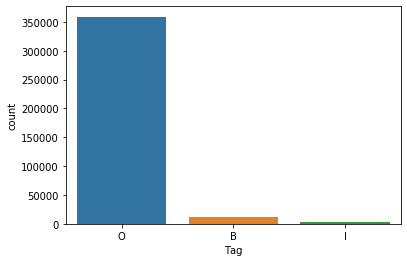

In [79]:
import seaborn as sns
sns.countplot(final_data['Tag'])

In [80]:
final_data['Tag'].value_counts()

O    358953
B     12288
I      2941
Name: Tag, dtype: int64

In [81]:
df=final_data
df.loc[(df['Tag'] == 'B'), 'Tag'] = 'B-ORG'
df.loc[(df['Tag'] == 'I'), 'Tag'] = 'I-ORG'
df.to_csv("2000_BIO_taggingdata_ALL_ROW_WISE.csv",index=False)

In [ ]:
data["summaries"][12]

In [ ]:
# df=final_data2
# df.loc[(df['Tag'] == 'B'), 'Tag'] = 'B-ORG'
# df.loc[(df['Tag'] == 'I'), 'Tag'] = 'I-ORG'
# df.to_csv("BIO_taggingdata_B_MUST.csv",index=False)